In [38]:
from data.AI_generated.images.images_dataset1 import df_image1
from data.AI_generated.images.images_dataset2 import df_image2
from data.AI_generated.images.images_dataset3 import df_image3
from data.raw.professions import df_female, df_male
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 📊 Analyse: Beobachteter vs. tatsächlicher Genderanteil in Bildern

## Zusammenführen der Datensätze von raw_images_1, raw_images_2, raw_images_3 & Berechnung einiger statistischer Größen
Wir kombinieren alle 3 Bild-Datenframes, um pro Beruf den mittleren Frauen- und Männeranteil zu berechnen.

### Zusammenführen der Datensätze

In [39]:
df_all = pd.concat([df_image1, df_image2, df_image3])

### Berechnung der gewichteten Mittelwerte

In [40]:
df_mean = df_all.groupby("job").agg(
    tot_number_person=("number_person", "sum"),
    tot_number_female=("number_female", "sum"),
    tot_number_male=("number_male", "sum")
).reset_index()

df_mean["tot_percent_female"] = df_mean["tot_number_female"] / df_mean["tot_number_person"] *100
df_mean["tot_percent_male"] = df_mean["tot_number_male"] / df_mean["tot_number_person"] *100

#Füge die Mittelwerte zurück zu df_all (per Merge)
df_all = df_all.merge(
    df_mean[["job", "tot_percent_female", "tot_percent_male"]],
    on="job"
)

### Berechnung der gewichtenen Standardabweichungen

In [41]:
df_all["squared_dev_female"] = (df_all["number_person"]
                                * (df_all["percent_female"] - df_all["tot_percent_female"]) ** 2)

df_all["squared_dev_male"] = (df_all["number_person"] *
                              (df_all["percent_male"] -df_all["tot_percent_male"]) ** 2)

In [42]:
std_df = df_all.groupby("job").agg(
    sum_squared_dev_female=("squared_dev_female", "sum"),
    sum_squared_dev_male=("squared_dev_male", "sum"),
    total_persons=("number_person", "sum")
).reset_index()

# Standardabweichung berechnen
std_df["std_female"] = np.sqrt(std_df["sum_squared_dev_female"] / std_df["total_persons"])
std_df["std_male"] = np.sqrt(std_df["sum_squared_dev_male"] / std_df["total_persons"])

#Füge die gewichteten Standardabweichungen zurück zu df_all (per Merge)
df_all = df_all.merge(std_df[["job", "std_female", "std_male"]], on="job")

### Berechnung des 95%-Konfidenzintervalls

In [43]:
# z-Wert für 95% Konfidenzintervall
z = 1.96

# Konfidenzintervall hinzufügen
df_all["ci_female"] = z * df_all["std_female"] / np.sqrt(df_all["number_person"])
df_all["ci_male"] = z * df_all["std_male"] / np.sqrt(df_all["number_person"])

## Vorbereitung: Erstellung des DataFrames mit beobachteten und tatsächlichen Genderanteilen

In [44]:
print(df_female.head(2))
print(df_male.head(2))

                    job  percent_female
0                 Nurse            86.8
1  Kindergarten Teacher            96.8
                   job  percent_female
0  Construction Worker             4.3
1  Mechanical Engineer            11.4


In [45]:
df_real = pd.concat([df_female, df_male])
df_real["percent_male"] = 100 - df_real["percent_female"]

## Generiere den Plot

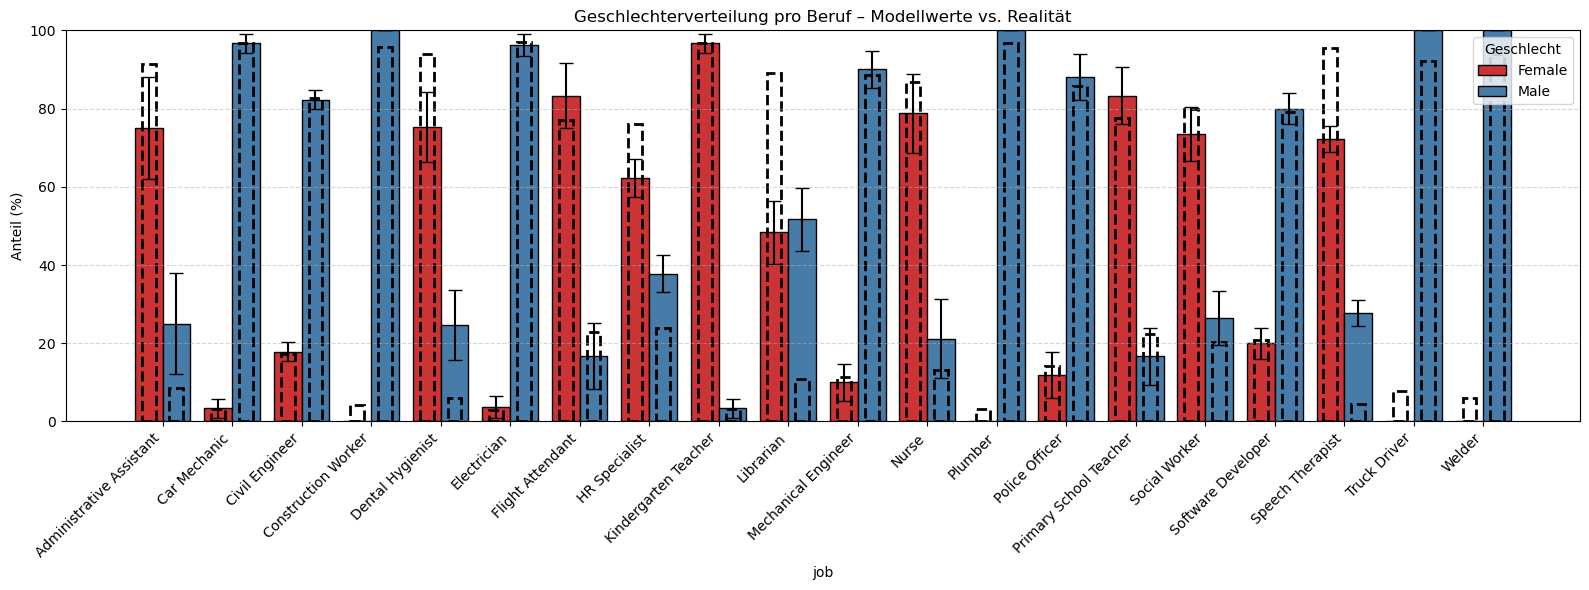

In [46]:
# Aggregiere Modellwerte (mit CI)
model_df = df_all.groupby("job").agg(
    mean_female=("percent_female", "mean"),
    ci_female=("ci_female", "mean"),
    mean_male=("percent_male", "mean"),
    ci_male=("ci_male", "mean")
).reset_index()

# Umstrukturieren für Plot
model_melted = model_df.melt(id_vars="job", value_vars=["mean_female", "mean_male"],
                             var_name="gender", value_name="percent")
ci_melted = model_df.melt(id_vars="job", value_vars=["ci_female", "ci_male"],
                          var_name="gender", value_name="ci")

model_melted["ci"] = ci_melted["ci"]
model_melted["gender"] = model_melted["gender"].str.replace("mean_", "").str.capitalize()

# Tatsächliche Werte vorbereiten
real_melted = df_real.melt(id_vars="job", value_vars=["percent_female", "percent_male"],
                           var_name="gender", value_name="real_percent")
real_melted["gender"] = real_melted["gender"].str.replace("percent_", "").str.capitalize()

# Merge: Modell mit realen Werten
plot_df = model_melted.merge(real_melted, on=["job", "gender"], how="left")

# Plotten
plt.figure(figsize=(16, 6))
sns.barplot(data=plot_df, x="job", y="percent", hue="gender", palette=["#e41a1c", "#377eb8"], edgecolor="black")

# Fehlerbalken manuell einfügen
bar_positions = {}
for i, (job, group) in enumerate(plot_df.groupby("job")):
    for j, row in group.iterrows():
        offset = -0.2 if row["gender"] == "Female" else 0.2
        bar_x = i + offset
        plt.errorbar(x=bar_x, y=row["percent"], yerr=row["ci"], fmt='none', ecolor='black', capsize=5)
        bar_positions[(job, row["gender"])] = bar_x

# Tatsächliche Werte (als gestrichelte Balken)
for i, row in plot_df.iterrows():
    x = bar_positions[(row["job"], row["gender"])]
    plt.bar(x, row["real_percent"], width=0.2, color='none', edgecolor='black', linestyle='--', linewidth=2, label="_nolegend_")

# Legenden und Beschriftung
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Geschlecht")

plt.ylim(0, 100)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Anteil (%)")
plt.title("Geschlechterverteilung pro Beruf – Modellwerte vs. Realität")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
# 1. Transformation ins lange Format für beobachtete Werte
observed_long = df_image.melt(
    id_vars=["job"],
    value_vars=["percent_female", "percent_male"],
    var_name="gender",
    value_name="percentage"
)
observed_long["gender"] = observed_long["gender"].str.replace("percent_", "")


In [19]:
# 2. Transformation ins lange Format für reale Werte
real_long = df_real.melt(
    id_vars=["job"],
    value_vars=["percent_female", "percent_male"],
    var_name="gender",
    value_name="real_percentage"
)
real_long["gender"] = real_long["gender"].str.replace("percent_", "")

In [20]:
# 3. Mergen beider DataFrames
observed_long = observed_long.merge(real_long, on=["job", "gender"], how="left")

In [21]:
observed_long.head(10)

,job,gender,percentage,real_percentage
0,Nurse,female,50.000000,86.8
1,Kindergarten Teacher,female,90.000000,96.8
2,Flight Attendant,female,60.000000,77.2
3,Administrative Assistant,female,40.000000,91.4
4,Dental Hygienist,female,90.909091,93.9
5,Social Worker,female,90.000000,79.8
6,Speech Therapist,female,66.666667,95.4
7,Librarian,female,70.000000,89.2
8,HR Specialist,female,66.666667,76.1
9,Primary School Teacher,female,80.000000,77.7


## 📊 Vergleich: Beobachtete vs. tatsächliche Genderverteilung pro Beruf
Dieser Abschnitt visualisiert die extrahierten Gender-Anteile (aus den generierten Bildern) im Vergleich zu den tatsächlichen Anteilen in der Bevölkerung.

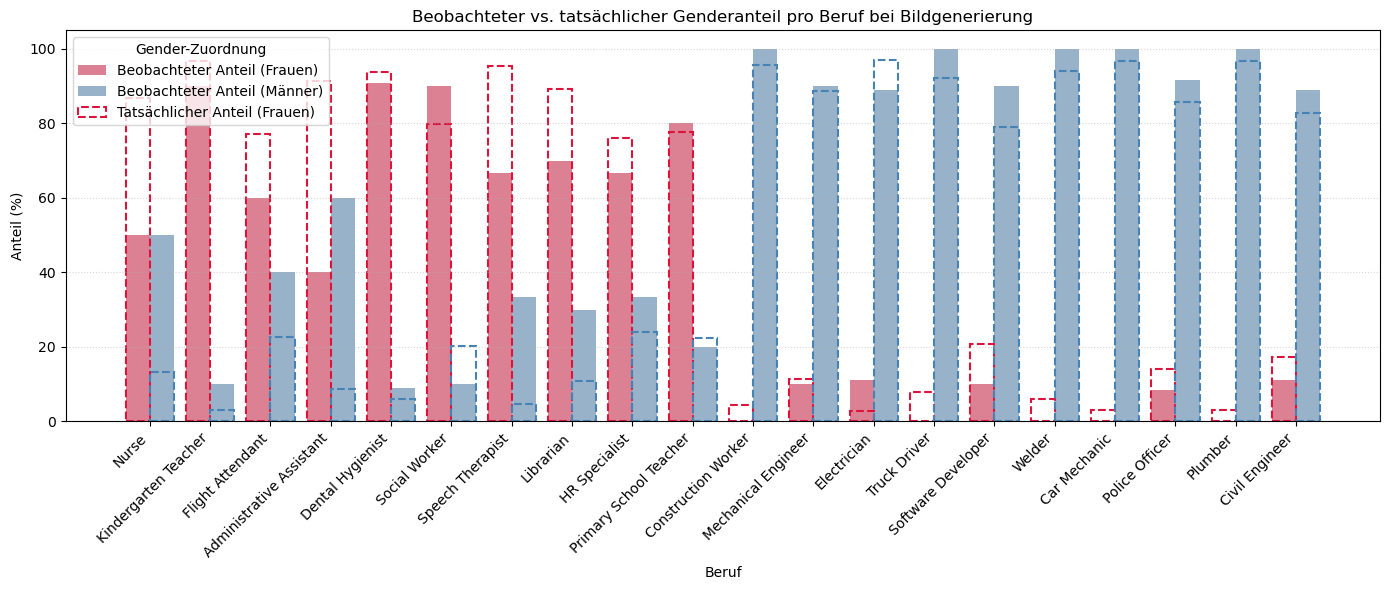

In [22]:
# 🎨 Farben & Sortierung
palette = {"female": "crimson", "male": "steelblue"}
jobs_sorted = observed_long["job"].unique()

# 📊 Plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(
    data=observed_long,
    x="job", y="percentage", hue="gender",
    palette=palette, order=jobs_sorted,
    hue_order=["female", "male"], dodge=True
)

# 🎯 Transparenz für beobachtete Werte
for patch in barplot.patches:
    patch.set_alpha(0.6)

# ➖ Tatsächliche Anteile als gestrichelte Linien
for i, row in observed_long.iterrows():
    xpos = list(jobs_sorted).index(row["job"])
    offset = -0.2 if row["gender"] == "female" else 0.2
    plt.bar(
        xpos + offset,
        row["real_percentage"],
        width=0.4,
        color="none",
        edgecolor=palette[row["gender"]],
        linestyle="--",
        linewidth=1.5,
        label=f"real {row['gender']}" if i < 2 else None
    )

# 🛠 Layout
plt.title("Beobachteter vs. tatsächlicher Genderanteil pro Beruf bei Bildgenerierung")
plt.ylabel("Anteil (%)")
plt.xlabel("Beruf")
plt.xticks(rotation=45, ha="right")

# 🧭 Legende
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
de_labels = {
    "female": "Beobachteter Anteil (Frauen)",
    "male": "Beobachteter Anteil (Männer)",
    "real female": "Tatsächlicher Anteil (Frauen)",
    "real male": "Tatsächlicher Anteil (Männer)"
}
plt.legend(by_label.values(), [de_labels.get(k, k) for k in by_label], title="Gender-Zuordnung")

plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()